### Scenario Background Profile Plotter
A python script to visualize the background profile of the created scenario, taken from `wrfinput` file
#### How to Use
* A

In [1]:
from netCDF4 import Dataset
from glob import glob
import numpy as np
from wrf import getvar, ALL_TIMES, extract_times
import math

In [4]:
import matplotlib.pyplot as plt
from time import time

RUN_ID = {
    'tokyo':    88,
    'cairo':    86,
}
rural_land_type = 'barren'

plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

file_name = glob(f'/home/mok/miniguc/runs/{RUN_ID['tokyo']:03}-*/wrfinput*')[0]
dummy_dataset: Dataset = Dataset(file_name)

# Print variables
print('Variable names:')
for x in dummy_dataset.variables.values():
    unit = dummy_dataset.variables[x.name].__dict__.get('units')
    print(f'{x.name}: {dummy_dataset.variables[x.name].__dict__.get('description')} ({unit})')

Variable names:
Times: None (None)
XLAT: LATITUDE, SOUTH IS NEGATIVE (degree_north)
XLONG: LONGITUDE, WEST IS NEGATIVE (degree_east)
LU_INDEX: LAND USE CATEGORY ()
ZNU: eta values on half (mass) levels ()
ZNW: eta values on full (w) levels ()
ZS: DEPTHS OF CENTERS OF SOIL LAYERS (m)
DZS: THICKNESSES OF SOIL LAYERS (m)
VAR_SSO: variance of subgrid-scale orography (m2)
EROD: fraction of erodible surface in each grid cell (0-1) (none)
BATHYMETRY_FLAG: Flag for bathymetry in the global attributes for metgrid data (-)
U: x-wind component (m s-1)
V: y-wind component (m s-1)
W: z-wind component (m s-1)
PH: perturbation geopotential (m2 s-2)
PHB: base-state geopotential (m2 s-2)
T: perturbation potential temperature theta-t0 (K)
THM: either 1) pert moist pot temp=(1+Rv/Rd Qv)*(theta)-T0, or 2) pert dry pot temp=t (K)
T_INIT: initial potential temperature (K)
MU: perturbation dry air mass in column (Pa)
MUB: base state dry air mass in column (Pa)
P: perturbation pressure (Pa)
AL: inverse pertur

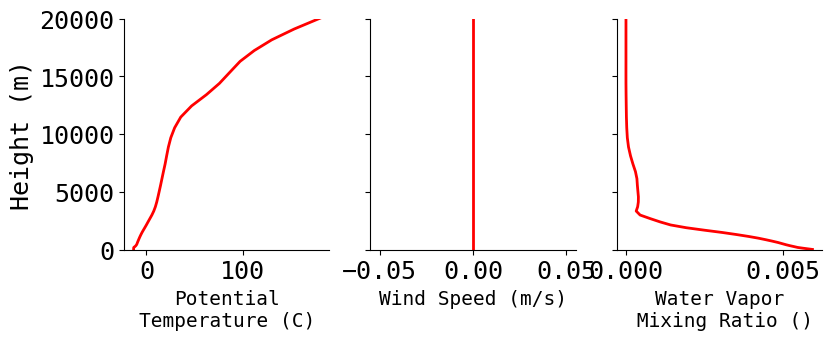

In [8]:
times = []

ANALYZE_VARS = ['T', 'SPEED', 'QVAPOR']
fig, axes = plt.subplots(1, len(ANALYZE_VARS), figsize=(9, 3), sharey='row')

custom_var_unit = {
    'SPEED': 'm/s',
    'T': 'C',
    'QVAPOR': '',
}

custom_var_name = {
    'SPEED': 'Wind Speed',
    'T': 'Potential\nTemperature',
    'W': 'Vertical Wind Speed',
    'QVAPOR': 'Water Vapor\n Mixing Ratio',
}

for i, var_name in enumerate(ANALYZE_VARS):
    print(f'Processing {var_name} of {rural_land_type}...' + (' ' * 40), end='\r')
    mean_var_values = []
    mean_var_values_urban = []
    mean_var_values_rural = []

    wrfinput_name = glob(f'/home/mok/miniguc/runs/{RUN_ID['cairo']:03}-*/wrfinput*')[0]
    wrfinput = Dataset(wrfinput_name)

    if var_name == 'SPEED':
        u_values = getvar(wrfinput, 'U', timeidx=ALL_TIMES)
        mean_u_values = np.mean(u_values, axis=(1, 2))

        v_values = getvar(wrfinput, 'V', timeidx=ALL_TIMES)
        mean_v_values = np.mean(v_values, axis=(1, 2))

        mean_var_values = np.sqrt(mean_u_values**2 + mean_v_values**2)
    else:
        var_values = getvar(wrfinput, var_name, timeidx=ALL_TIMES)
        mean_var_values = np.mean(var_values, axis=(1, 2))

    z_values = getvar(wrfinput, 'z', timeidx=ALL_TIMES)
    mean_z_values = np.mean(z_values, axis=(1, 2))

    axes[i].plot(mean_var_values[:len(mean_z_values)], mean_z_values, '-', color='red', mfc='white', linewidth=2)
    axes[i].set_ylim(0, 20000)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    var_unit = wrfinput.variables[var_name].units if not var_name in custom_var_unit else custom_var_unit[var_name]
    axes[i].set_xlabel(f'{var_name if not var_name in custom_var_name else custom_var_name[var_name]} ({var_unit})', { 'size': 14 })

axes[0].set_ylabel(f'Height (m)')
# fig.suptitle(f'Plot of Variables Background Profile')

plt.savefig(f'/home/mok/miniguc/results/var-comparison/loc-var-profile-cairo.png')